# 从0开始优化算法

* ### **Momentum**

\begin{align*}
\mathbf{v} &:= \gamma \mathbf{v} + \eta \nabla f_\mathcal{B}(\mathbf{x}),\\
\mathbf{x} &:= \mathbf{x} - \mathbf{v}
\end{align*}

* ### **Adagrad**

\begin{align*}
\mathbf{s} &:= \mathbf{s} + \mathbf{g} \odot \mathbf{g}, \\
\mathbf{g}^\prime &:= \frac{\eta}{\sqrt{\mathbf{s} + \epsilon}} \odot \mathbf{g}, \\
\mathbf{x} &:= \mathbf{x} - \mathbf{g}^\prime
\end{align*}

* ### **RMSprop**

\begin{align*}
\mathbf{s} &:= \gamma \mathbf{s} + (1 - \gamma) \mathbf{g} \odot \mathbf{g},\\
\mathbf{g}^\prime &:= \frac{\eta}{\sqrt{\mathbf{s} + \epsilon}} \odot \mathbf{g},\\
\mathbf{x} &:= \mathbf{x} - \mathbf{g}^\prime
\end{align*}

* ### **Adadelta**

\begin{align*}
\mathbf{s} &:= \rho \mathbf{s} + (1 - \rho) \mathbf{g} \odot \mathbf{g},\\
\mathbf{g}^\prime &= \frac{\sqrt{\Delta\mathbf{x} + \epsilon}}{\sqrt{\mathbf{s} + \epsilon}}   \odot \mathbf{g},\\
\Delta\mathbf{x} &:= \rho \Delta\mathbf{x} + (1 - \rho) \mathbf{g}^\prime \odot \mathbf{g}^\prime,\\
\mathbf{x} &:= \mathbf{x} - \mathbf{g}^\prime
\end{align*}

* ### **Adam**

\begin{align*}
t &:= t + 1,\\
\mathbf{v} &:= \beta_1 \mathbf{v} + (1 - \beta_1) \mathbf{g},\\
\mathbf{s} &:= \beta_2 \mathbf{s} + (1 - \beta_2) \mathbf{g} \odot \mathbf{g},\\
\hat{\mathbf{v}} &:= \frac{\mathbf{v}}{1 - \beta_1^t},\\
\hat{\mathbf{s}} &:= \frac{\mathbf{s}}{1 - \beta_2^t},\\
\mathbf{g}^\prime &:= \frac{\eta \hat{\mathbf{v}}}{\sqrt{\hat{\mathbf{s}} + \epsilon}},\\
\mathbf{x} &:= \mathbf{x} - \mathbf{g}^\prime
\end{align*}

* ### **Nesterov accelerated gradient(NAG)**

\begin{align*}
\mathbf{v} &:= \gamma \mathbf{v} + \eta \nabla f_\mathcal{B}(\mathbf{x - \gamma \mathbf{v}}),\\
\mathbf{x} &:= \mathbf{x} - \mathbf{v}
\end{align*}

* ### **AdaMax**

* ### **Nadam(Nesterov-accelerated Adaptive Moment Estimation)**

## 算法可视化

### 1.Long Valley
<img src="https://i.imgur.com/2dKCQHh.gif?1" width="500">

### 2.Beale's function
<img src="https://i.imgur.com/pD0hWu5.gif?1" width="500">

### 3.Saddle Point
<img src="https://i.imgur.com/NKsFHJb.gif?1" width="500">

In [1]:
import mxnet as mx
import numpy as np
import random

from mxnet import nd
from mxnet import gluon
from mxnet import autograd

%matplotlib inline
import matplotlib as mlt
import matplotlib.pyplot as plt
mlt.rcParams['figure.dpi'] = 120

ctx = mx.cpu()

mx.random.seed(1)
random.seed(1) 

## 优化算法

In [2]:
# 1.Momentum
def sgd_momentum(params, vs, lr, mom, batch_size):
    for param, v in zip(params, vs):
        v[:] = mom * v + lr * param.grad / batch_size
        param[:] = param - v
        
# 2.Adagrad
def adagrad(params, sq, lr, batch_size, eps=1e-6):
    for param, s in zip(params, sq):
        s[:] = s + nd.square(param.grad / batch_size)
        gg = lr / nd.sqrt(s + eps) * param.grad
        param[:] = param - gg

# 3.rmsprop
def rmsprop(params, sq, lr, mom, batch_size, eps=1e-6):
    for param, s in zip(params, sq):
        s[:] = mom * s + (1 - mom) * nd.square(param.grad / batch_size)
        gg = lr / nd.sqrt(s + eps) * param.grad
        param[:] = param - gg
    
# 4.adadelta
def adadelta(params, sq, deltax, rhu, batch_size, eps=1e-6):
    for param, s, dx in zip(params, sq, deltax):
        s[:] = rhu * s + (1 - rhu) * nd.square(param.grad / batch_size)
        gg = nd.sqrt(dx + eps) / nd.sqrt(s + eps) * param.grad
        dx[:] = rhu * dx + (1 - rhu) * nd.square(gg * gg)
        param[:] = param - gg

# Adam
def adam(params, vs, sq, beta1, beta2, lr, batch_size, eps=1e-8):
    t = 1
    for param, v, s in zip(params, vs, sq):
        v[:] = beta1 * v + (1-beta1) * param.grad / batch_size
        s[:] = beta2 * s + (1-beta2) * nd.square(param.grad / batch_size)
        v_prime = v / (1 - beta1**t)
        s_prime = s / (1 - beta2**t)
        gg = lr * v_prime / nd.sqrt(s_prime + eps)
        param[:] = param - gg
        t+=1

# Nesterov
def nesterov(params, vs, lr, lambd, batch_size):
    for param, v in zip(params, vs):
        param[:] = param - lambd * v
        v[:] = lambd * v + lr * param.grad / batch_size
        param[:] = param - v

\begin{align*}
\mathbf{v} &:= \gamma \mathbf{v} + \eta \nabla f_\mathcal{B}(\mathbf{x - \gamma \mathbf{v}}),\\
\mathbf{x} &:= \mathbf{x} - \mathbf{v}
\end{align*}

In [3]:
true_w = [2.0, -3.4]
true_b = 4.2

num_examples = 1000
num_inputs = 2
num_outputs = 1

X = nd.random.normal(shape=(num_examples, num_inputs))
y = true_w[0] * X[:, 0] + true_w[1] * X[:, 1] + true_b
y += .01 * nd.random.normal(shape=(num_examples))

In [4]:
# 1.momentum
def init_params_mom():
    W = nd.random.normal(shape=(num_inputs, num_outputs))
    b = nd.random.normal(shape=num_outputs) 
    params = [W, b]
    # 动量
    vs = []
    for param in params:
        param.attach_grad()
        vs.append(param.zeros_like())
    return params, vs

# 2.adagrad
def init_params_adagrad():
    W = nd.random.normal(shape=(num_inputs, num_outputs))
    b = nd.random.normal(shape=num_outputs) 
    params = [W, b]
    # 动量
    sq = []
    for param in params:
        param.attach_grad()
        sq.append(param.zeros_like())
    return params, sq

# 3.rmsprop
def init_params_rmsprop():
    W = nd.random.normal(shape=(num_inputs, num_outputs))
    b = nd.random.normal(shape=num_outputs) 
    params = [W, b]
    # 动量
    sq = []
    for param in params:
        param.attach_grad()
        sq.append(param.zeros_like())
    return params, sq

# 4.adadelta
def init_params_adadelta():
    W = nd.random.normal(shape=(num_inputs, num_outputs))
    b = nd.random.normal(shape=num_outputs)
    params = [W, b]
    sq = []
    deltax = []
    for param in params:
        param.attach_grad()
        sq.append(param.zeros_like())
        deltax.append(param.zeros_like())
    return params, sq, deltax

# 5.adam
def init_params_adam():
    W = nd.random.normal(shape=(num_inputs, num_outputs))
    b = nd.random.normal(shape=num_outputs)
    params = [W, b]
    vs = []
    sq = []
    for param in params:
        param.attach_grad()
        vs.append(param.zeros_like())
        sq.append(param.zeros_like())
    return params, vs, sq

# 6.nesterov
def init_params_nestrov():
    W = nd.random.normal(shape=(num_inputs, num_outputs))
    b = nd.random.normal(shape=num_outputs)
    params = [W, b]
    vs = []
    for param in params:
        param.attach_grad()
        vs.append(param.zeros_like())
    return params, vs

def data_iter(batch_size):
    idx = list(range(X.shape[0]))
    random.shuffle(idx)
    for i in range(0, len(idx), batch_size):
        j = nd.array(idx[i:min(i+batch_size, num_examples)])
        yield i, X.take(j), y.take(j)
    
def square_loss(yhat, y):
    return (yhat - y.reshape(yhat.shape))**2 / 2

def net(X, W, b):
    return nd.dot(X, W) + b

In [5]:
def train_mom(batch_size, lr, epochs, period, mom=0.9):
    assert period >= batch_size and period % batch_size == 0
    
    [W, b], vs = init_params_mom()
    total_loss = [nd.mean(square_loss(net(X, W, b), y)).asnumpy()]
    for epoch in range(epochs):
        if epoch > 2:
            lr *= 0.1
        for batch_i, data, label in data_iter(batch_size):
            with autograd.record():
                output = net(data, W, b)
                loss = square_loss(output, label)
            loss.backward()
            sgd_momentum([W, b], vs, lr, mom, batch_size)
            
            if not batch_i * batch_size % period:
                total_loss.append(nd.mean(square_loss(net(X, W, b), y)).asnumpy())
                           
        print("Epoch %d, lr : %s, Train Loss %.5f." % (epoch, lr, total_loss[-1]))
    print("W : %s, b : %s" % (W.reshape((2,)).asnumpy(), b.asnumpy()))
    
    Xlabel = np.linspace(0, epochs, len(total_loss), endpoint=True)
    plt.semilogy(Xlabel, total_loss, color="g")
    plt.grid(True, which="both")
    plt.show()

Epoch 0, lr : 0.1, Train Loss 0.00015.
Epoch 1, lr : 0.1, Train Loss 0.00005.
Epoch 2, lr : 0.1, Train Loss 0.00006.
W : [ 1.99986112 -3.40122652], b : [ 4.19654369]


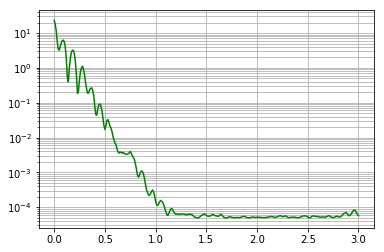

In [6]:
train_mom(batch_size=10, lr=0.1, epochs=3, period=10, mom=0.9)

In [7]:
def train_adagrad(batch_size, lr, epochs, period):
    assert period >= batch_size and period % batch_size == 0
    
    [W, b], sq = init_params_adagrad()
    total_loss = [nd.mean(square_loss(net(X, W, b), y)).asnumpy()]
    for epoch in range(epochs):
        if epoch > 2:
            lr *= 0.1
        for batch_i, data, label in data_iter(batch_size):
            with autograd.record():
                output = net(data, W, b)
                loss = square_loss(output, label)
            loss.backward()
            adagrad([W, b], sq, lr, batch_size)
            
            if not batch_i * batch_size % period:
                total_loss.append(nd.mean(square_loss(net(X, W, b), y)).asnumpy())
                           
        print("Epoch %d, lr : %s, Train Loss %.5f." % (epoch, lr, total_loss[-1]))
    print("W : %s, b : %s" % (W.reshape((2,)).asnumpy(), b.asnumpy()))
    
    Xlabel = np.linspace(0, epochs, len(total_loss), endpoint=True)
    plt.semilogy(Xlabel, total_loss, color="g")
    plt.grid(True, which="both")
    plt.show()

Epoch 0, lr : 0.1, Train Loss 0.00005.
Epoch 1, lr : 0.1, Train Loss 0.00005.
Epoch 2, lr : 0.1, Train Loss 0.00005.
W : [ 2.00108695 -3.40031028], b : [ 4.19919634]


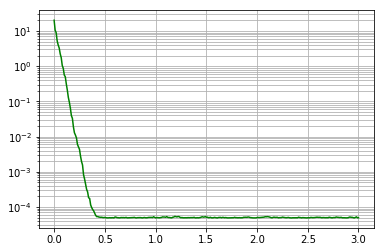

In [8]:
train_adagrad(batch_size=10, lr=0.1, epochs=3, period=10)

In [9]:
def train_rmsprop(batch_size, lr, epochs, period, mom=0.9):
    assert period >= batch_size and period % batch_size == 0
    
    [W, b], sq = init_params_adagrad()
    total_loss = [nd.mean(square_loss(net(X, W, b), y)).asnumpy()]
    for epoch in range(epochs):
        if epoch > 2:
            lr *= 0.1
        for batch_i, data, label in data_iter(batch_size):
            with autograd.record():
                output = net(data, W, b)
                loss = square_loss(output, label)
            loss.backward()
            rmsprop([W, b], sq, lr, mom, batch_size)
            
            if not batch_i * batch_size % period:
                total_loss.append(nd.mean(square_loss(net(X, W, b), y)).asnumpy())
                           
        print("Epoch %d, lr : %s, Train Loss %.5f." % (epoch, lr, total_loss[-1]))
    print("W : %s, b : %s" % (W.reshape((2,)).asnumpy(), b.asnumpy()))
    
    Xlabel = np.linspace(0, epochs, len(total_loss), endpoint=True)
    plt.semilogy(Xlabel, total_loss, color="g")
    plt.grid(True, which="both")
    plt.show()

Epoch 0, lr : 0.02, Train Loss 0.00005.
Epoch 1, lr : 0.02, Train Loss 0.00157.
Epoch 2, lr : 0.02, Train Loss 0.00052.
W : [ 2.00606918 -3.3850317 ], b : [ 4.22572231]


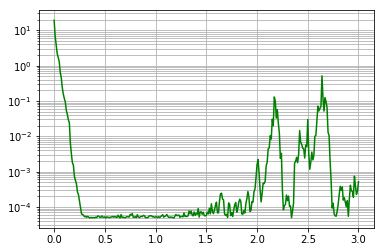

In [24]:
train_rmsprop(batch_size=10, lr=0.02, epochs=3, period=10, mom=0.98)

In [11]:
def train_adadelta(batch_size, epochs, period, rho=0.9):
    assert period >= batch_size and period % batch_size == 0
    
    [W, b], sq, deltax = init_params_adadelta()
    total_loss = [nd.mean(square_loss(net(X, W, b), y)).asnumpy()]
    for epoch in range(epochs):
        for batch_i, data, label in data_iter(batch_size):
            with autograd.record():
                output = net(data, W, b)
                loss = square_loss(output, label)
            loss.backward()   
            adadelta([W, b], sq, deltax, rho, batch_size)
            
            if not batch_i * batch_size % period:
                total_loss.append(nd.mean(square_loss(net(X, W, b), y)).asnumpy())
                           
        print("Epoch %d, Train Loss %.5f." % (epoch, total_loss[-1]))
    print("W : %s, b : %s" % (W.reshape((2,)).asnumpy(), b.asnumpy()))
    
    Xlabel = np.linspace(0, epochs, len(total_loss), endpoint=True)
    plt.semilogy(Xlabel, total_loss, color="g")
    plt.grid(True, which="both")
    plt.show()

Epoch 0, Train Loss 0.00214.
Epoch 1, Train Loss 0.00005.
Epoch 2, Train Loss 0.00005.
W : [ 2.00067925 -3.39983249], b : [ 4.19982529]


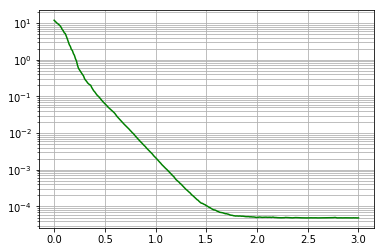

In [31]:
train_adadelta(batch_size=10, epochs=3, period=10, rho=0.99)

In [13]:
def train_adam(batch_size, epochs, period, lr, beta1, beta2):
    assert period >= batch_size and period % batch_size == 0
    
    [W, b], vs, sq = init_params_adam()
    total_loss = [nd.mean(square_loss(net(X, W, b), y)).asnumpy()]
    for epoch in range(epochs):
        for batch_i, data, label in data_iter(batch_size):
            with autograd.record():
                output = net(data, W, b)
                loss = square_loss(output, label)
            loss.backward()   
            adam([W, b], vs, sq, beta1, beta2, lr, batch_size)
            
            if not batch_i * batch_size % period:
                total_loss.append(nd.mean(square_loss(net(X, W, b), y)).asnumpy())
                           
        print("Epoch %d, lr %s, Train Loss %.5f." % (epoch, lr, total_loss[-1]))
    print("W : %s, b : %s" % (W.reshape((2,)).asnumpy(), b.asnumpy()))
    
    Xlabel = np.linspace(0, epochs, len(total_loss), endpoint=True)
    plt.semilogy(Xlabel, total_loss, color="g")
    plt.grid(True, which="both")
    plt.show()

Epoch 0, lr 0.1, Train Loss 0.00035.
Epoch 1, lr 0.1, Train Loss 0.00005.
Epoch 2, lr 0.1, Train Loss 0.00005.
W : [ 2.00034428 -3.39987326], b : [ 4.19990492]


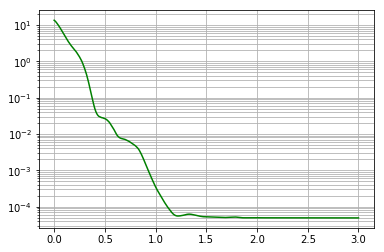

In [14]:
train_adam(batch_size=10, epochs=3, period=10, lr=0.1, beta1=0.9, beta2=0.999)

In [15]:
def train_nesterov(batch_size, lr, epochs, period, lambd=0.9):
    assert period >= batch_size and period % batch_size == 0
    
    [W, b], vs = init_params_nestrov()
    total_loss = [nd.mean(square_loss(net(X, W, b), y)).asnumpy()]
    for epoch in range(epochs):
        if epoch > 2:
            lr *= 0.1
        for batch_i, data, label in data_iter(batch_size):
            with autograd.record():
                output = net(data, W, b)
                loss = square_loss(output, label)
            loss.backward()
            nesterov([W, b], vs, lr, lambd, batch_size)
            
            if not batch_i * batch_size % period:
                total_loss.append(nd.mean(square_loss(net(X, W, b), y)).asnumpy())
                           
        print("Epoch %d, lr : %s, Train Loss %.5f." % (epoch, lr, total_loss[-1]))
    print("W : %s, b : %s" % (W.reshape((2,)).asnumpy(), b.asnumpy()))
    
    Xlabel = np.linspace(0, epochs, len(total_loss), endpoint=True)
    plt.semilogy(Xlabel, total_loss, color="g")
    plt.grid(True, which="both")
    plt.show()

Epoch 0, lr : 0.01, Train Loss 0.00123.
Epoch 1, lr : 0.01, Train Loss 0.00005.
Epoch 2, lr : 0.01, Train Loss 0.00005.
W : [ 2.00004935 -3.40145946], b : [ 4.19971514]


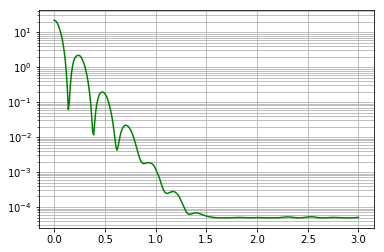

In [16]:
train_nesterov(batch_size=10, lr=0.01, epochs=3, period=10, lambd=0.9)